<a href="https://colab.research.google.com/github/Neark31/MLSource/blob/main/project1_USPatent.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Setup pour Kaggle data - source https://www.kaggle.com/code/jhoward/getting-started-with-nlp-for-absolute-beginners

#To  run once


In [2]:
import os
iskaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')

In [3]:
!pip install kaggle

In [4]:
creds = '{"username":"benjamin3127","key":"513f9c2982329e56ba59568c40b7fd2b"}'

In [5]:
from pathlib import Path

cred_path = Path('~/.kaggle/kaggle.json').expanduser()
if not cred_path.exists():
    cred_path.parent.mkdir(exist_ok=True)
    cred_path.write_text(creds)
    cred_path.chmod(0o600)

In [6]:
path = Path('us-patent-phrase-to-phrase-matching')

In [7]:
if not iskaggle and not path.exists():
    import zipfile,kaggle
    kaggle.api.competition_download_cli(str(path))
    zipfile.ZipFile(f'{path}.zip').extractall(path)



In [8]:
if iskaggle:
    path = Path('../input/us-patent-phrase-to-phrase-matching')
    ! pip install -q datasets



## Le cas


In [9]:
!ls {path}

sample_submission.csv  test.csv  train.csv


Pour manipuler des csv file, on utilise la librairie pandas

In [10]:
import pandas as pd

In [11]:
df = pd.read_csv(path/'train.csv')

On cree un panda dataset qui contien le fichier avec les données d'entrainement et on passe df pour afficher le resultat:

In [12]:
df

,id,anchor,target,context,score
0,37d61fd2272659b1,abatement,abatement of pollution,A47,0.50
1,7b9652b17b68b7a4,abatement,act of abating,A47,0.75
2,36d72442aefd8232,abatement,active catalyst,A47,0.25
3,5296b0c19e1ce60e,abatement,eliminating process,A47,0.50
4,54c1e3b9184cb5b6,abatement,forest region,A47,0.00
...,...,...,...,...,...
36468,8e1386cbefd7f245,wood article,wooden article,B44,1.00
36469,42d9e032d1cd3242,wood article,wooden box,B44,0.50
36470,208654ccb9e14fa3,wood article,wooden handle,B44,0.50
36471,756ec035e694722b,wood article,wooden material,B44,0.75


La méthode df sur le dataset afficher un résumé des données

In [13]:
df.describe(include='object')

,id,anchor,target,context
count,36473,36473,36473,36473
unique,36473,733,29340,106
top,37d61fd2272659b1,component composite coating,composition,H01
freq,1,152,24,2186


De retour au cours, on va concatener les elements de chaque ligne avec des balises pour les passer en input. Avec pandas, le signe + sert a concatener

In [14]:
df['input'] = 'TEXT1: ' + df.context + '; TEXT2: ' + df.target + '; ANC1: ' + df.anchor


On peut voir les premiers leigne de notre input avec la methode head:

In [15]:
df.input.head()

0    TEXT1: A47; TEXT2: abatement of pollution; ANC...
1    TEXT1: A47; TEXT2: act of abating; ANC1: abate...
2    TEXT1: A47; TEXT2: active catalyst; ANC1: abat...
3    TEXT1: A47; TEXT2: eliminating process; ANC1: ...
4    TEXT1: A47; TEXT2: forest region; ANC1: abatement
Name: input, dtype: object

On importe maintenant la librairie dataset de hugging face qui nous permet d'utiliser un objet "dataset" qui sert a stocker des dataset lie aux transformersd e hugging face.on va lui passer notre objet pandaq

In [16]:
!pip install datasets

In [17]:
from datasets import Dataset,DatasetDict

ds = Dataset.from_pandas(df)

on teste a quoi cela ressemble:

In [18]:
ds

Dataset({
    features: ['id', 'anchor', 'target', 'context', 'score', 'input'],
    num_rows: 36473
})

L'etape suivante va etre de convertir les textes du dataset en nombre car nos modeles de ML ne lisent pas des textes mais font des calculs avec des nombres. ce sont ces nombres au nous passeront dans le modele. il va falloir tokenizer le texte (convertir mot en token) puis Numericalization les token(les convertir en nombre). la facon dont ces 2 étapes sont faites dependra du modele ou l'on choisit de les passer. on cmmence donc d'abord par choisir un modele

On choisit donc tout d'abord un modele pour la tokenization, ici DeBERTa: Decoding-enhanced BERT with Disentangled Attention

In [19]:
model_nm = 'microsoft/deberta-v3-small'

Puis on va tokenizer le datasetr en accord avec le modele. hugging face le fait pour nous avec AutoTokenizer. l'installation de transforer difffre un peu du cours suite a la relase v4 d'hugging face

In [20]:
!pip install --no-cache-dir transformers sentencepiece

In [21]:
from transformers import AutoModelForSequenceClassification,AutoTokenizer

In [22]:
tokz = AutoTokenizer.from_pretrained(model_nm, use_fast = False)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Un exemple de comment la tokennization fonctionne. le caractère - indique le debut d'un mot

In [23]:
tokz.tokenize("G'day folks, I'm Jeremy from fast.ai!")

['▁G',
 "'",
 'day',
 '▁folks',
 ',',
 '▁I',
 "'",
 'm',
 '▁Jeremy',
 '▁from',
 '▁fast',
 '.',
 'ai',
 '!']

On crée maintenant une fonction qui va tokeniser notre dataset

In [24]:
def tok_func(x): return tokz(x["input"])

et on la lance en utilisant map pour que les lignes soit traites parallelemlent et donc plus rapidement

In [25]:
tok_ds = ds.map(tok_func, batched=True)

Map:   0%|          | 0/36473 [00:00<?, ? examples/s]

Cela a ajouté de nouveaux input a notre dataset appeles input_ids. on peut les voir ainsi, par exemple la premiere ligne du dataset

In [26]:
row = tok_ds[0]
row['input'], row['input_ids']

('TEXT1: A47; TEXT2: abatement of pollution; ANC1: abatement',
 [1,
  54453,
  435,
  294,
  336,
  5753,
  346,
  54453,
  445,
  294,
  47284,
  265,
  6435,
  346,
  23702,
  435,
  294,
  47284,
  2])

Dans le tokenizer que l'on a utilisé, il y a une liste appelé vocab qui contient une valeur pour tous les token exiqtant. et c'est donc un simple vlookup qui q ete effectue sur chque token pour le matcher a son nombre. On peut tester le mapping ainsi, par exemple pour le mot/token "of" qui se trouve dans notre exemple ci dessus

In [27]:
tokz.vocab['▁of']

265

L'etape suivante va etre d'identifier nos label, dans notre cas la collone score. on va la renommer en label car c'est une obligation de la librairie hugging face

In [28]:
tok_ds = tok_ds.rename_columns({'score':'labels'})

Etape suivante est de creer notre validatione et test dataset. dans cete competition kaggle ils sont crees pour nous. le test set est un fichier consultable (test.csv) alors que le validationon va en avoir besoin pour mesurer l'efficacité de notre modele.

On passe le fichier test dans une variable pour voir ce que ca vaut

In [29]:
eval_df = pd.read_csv(path/'test.csv')
eval_df.describe()

,id,anchor,target,context
count,36,36,36,36
unique,36,34,36,29
top,4112d61851461f60,el display,inorganic photoconductor drum,G02
freq,1,2,1,3


on voit que cela contient que 36 lignes

Maintenant on va aussi creer un validation set. ce dataset ne sera jamais utilisé pour entrainer notre modele mais seulement pour mesurer son efficacité.

Voici une demonstration de son utilité. On va tracer une coubre représentant une fonction quadratique(equation du second degre). on utilise la librairie numpy pour ca. On definit d'abord un fonction puis on l'associe au graph

In [30]:
def f(x): return -3*x**2 + 2*x + 20
import numpy as np, matplotlib.pyplot as plt

def plot_function(f, min=-2.1, max=2.1, color='r'):
    x = np.linspace(min,max, 100)[:,None]
    plt.plot(x, f(x), color)

On peu maintenant la tracer ainsi

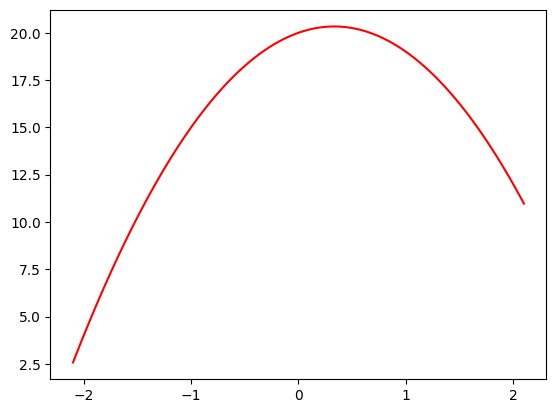

In [31]:
plot_function(f)

Pour la demonstration, on va creer un nuage de point random mais basé sur notre fonction.

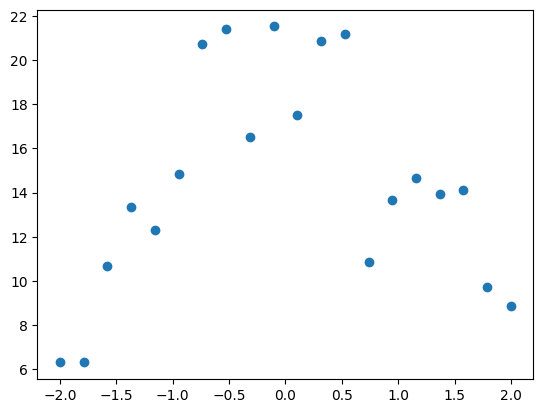

In [32]:


from numpy.random import normal,seed,uniform
np.random.seed(42)

def noise(x, scale): return normal(scale=scale, size=x.shape)
def add_noise(x, mult, add): return x * (1+noise(x,mult)) + noise(x,add)

x= np.linspace(-2, 2, num=20)[:,None]
y = add_noise(f(x), 0.2, 1.3)
plt.scatter(x,y);

On importe maintenant une librairer qui nous permet d'y applique des fonction de different degré(une ligne est degree 1, quadratic est degree 2, cubic est degree 3, etc). et on va en tester plyusieurs pour voir celle qui s'en rapprocherai le plus.

In [33]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

def plot_poly(degree):
    model = make_pipeline(PolynomialFeatures(degree), LinearRegression())
    model.fit(x, y)
    plt.scatter(x,y)
    plot_function(model.predict)

on regarde la fonction du 1er degres, donc une seule ligne

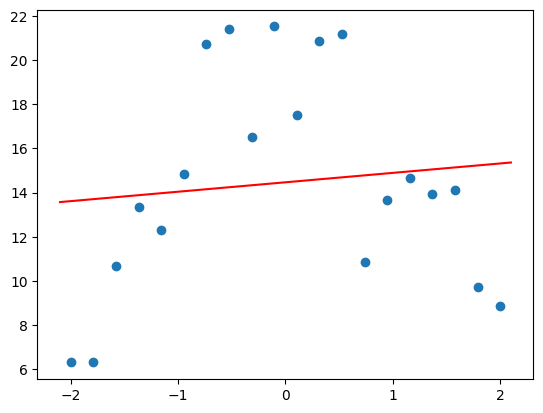

In [34]:
plot_poly(1)

Pas terrible, cette fonction underfit. maintenant une focntion du 10eme degres

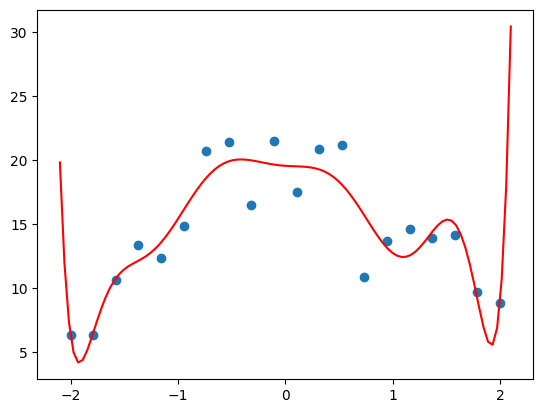

In [35]:
plot_poly(10)

La c'est trop bon, donc overfit. la fonction est trop similaire a notre dataset et donc ne donnera probablement de bonne prediction. Maintenant on va passer une qudrqtic et la comparer a la fonction correcte (en bleu)

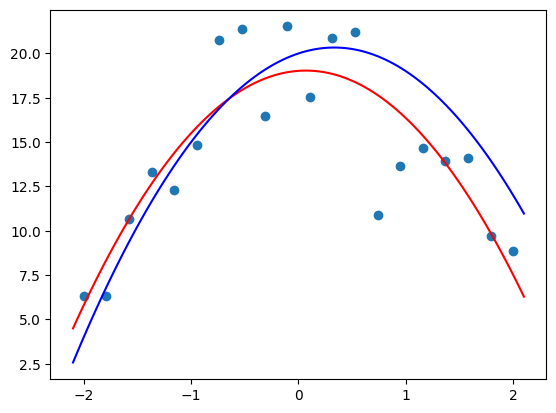

In [36]:
plot_poly(2)
plot_function(f, color='b')

La on est bon. pour determiner si notre modele nous donne une fonction qui soit underfit, overfit ou marche on va utiliser le validation set. ce dataset on ne l'utilise pas dans notre training lmais seulement pour tester si notre modele marche aussi avec ce nouveau dataset

On revient a notre exercie et on cree un validation set a l'aide de la librairie de hugging face. cela va isoler 25% des lignes du dataser original et les mettre de cote

In [37]:
dds = tok_ds.train_test_split(0.25, seed=42)
dds

DatasetDict({
    train: Dataset({
        features: ['id', 'anchor', 'target', 'context', 'labels', 'input', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 27354
    })
    test: Dataset({
        features: ['id', 'anchor', 'target', 'context', 'labels', 'input', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 9119
    })
})

Attention toutefois. ici on l'a creer au hasard mais ce n'est pas forcement la bonne solution. par exemple sur un modele de prediction de données basé sur des dates. un bon validation set serait les dernierers dates du modele par exemple plutot que des lognes prises au hasards. Choisir un bon validation set qui fait sens est tres important

On revient au test set. celui la on ne l'utilisera meme pas pour mesurer la performance de notre modele. on ne l'utilise que qunand on q finit le training de notre modele. il sert a eviter le risk d'overfitting du a l'utilisation du validation set. la competion de kaggle reserve deux test set. un pour le leaderboaard public, et un autre caché qui tourne seulement a la fin de la competion. Il peut arriver qu'un modele marche bien sur le public mais pas sur le privé

On se cree notre propre test set a coté de celui de kaggle:

In [38]:
eval_df['input'] = 'TEXT1: ' + eval_df.context + '; TEXT2: ' + eval_df.target + '; ANC1: ' + eval_df.anchor
eval_ds = Dataset.from_pandas(eval_df).map(tok_func, batched=True)

Map:   0%|          | 0/36 [00:00<?, ? examples/s]

On peut maintenant passer au training. Hugging face a besoin d'une metric stocké dans un dictionnaire, qui est la valeur utilisé pour maitriser la performance. dans la competion de kaggle actuel c'est le pearson coefficient. on passe donc la collone d emtric du dataset dans un dictionnaire

In [39]:

def corr_d(eval_pred): return {'pearson': corr(*eval_pred)}

Et on commence le training dans Transformers

In [40]:
from transformers import TrainingArguments,Trainer

On définit le batch, c.a.d le nombre de ligne envoyé en meme temps au GPU. Le plus gros est le batch size, le plus rapide mais rique d'avoir une error out of memory. et un petit nombre d'epoch

*   Élément de liste
*   Élément de liste



In [41]:
bs = 128
epochs = 4

puis un hypermarameter, lelearning rate.The idea is to find the largest value you can, but which doesn't result in training failing. on test une petite valeur et on la double tant quer ca ne fait pas d'erreur

In [42]:


lr = 8e-5


n definit des argument comme demandé par HF. a voir plus en detail dans la librairie

In [43]:
!pip install 'transformers[torch]'

In [44]:
!pip install accelerate -U

In [45]:
from importlib.metadata import version

In [46]:
version('accelerate')

'0.21.0'

In [47]:
pip list

Package                          Version
-------------------------------- ---------------------
absl-py                          1.4.0
accelerate                       0.21.0
aiohttp                          3.8.4
aiosignal                        1.3.1
alabaster                        0.7.13
albumentations                   1.2.1
altair                           4.2.2
anyio                            3.7.1
appdirs                          1.4.4
argon2-cffi                      21.3.0
argon2-cffi-bindings             21.2.0
array-record                     0.4.0
arviz                            0.15.1
astropy                          5.2.2
astunparse                       1.6.3
async-timeout                    4.0.2
attrs                            23.1.0
audioread                        3.0.0
autograd                         1.6.2
Babel                            2.12.1
backcall                         0.2.0
beautifulsoup4                   4.11.2
bleach                           6.0.0

In [48]:
args = TrainingArguments('outputs', learning_rate=lr, warmup_ratio=0.1, lr_scheduler_type='cosine', fp16=True,
    evaluation_strategy="epoch", per_device_train_batch_size=bs, per_device_eval_batch_size=bs*2,
    num_train_epochs=epochs, weight_decay=0.01, report_to='none')

Et maintenant on peut entrainer le modele

In [49]:
model = AutoModelForSequenceClassification.from_pretrained(model_nm, num_labels=1)
trainer = Trainer(model, args, train_dataset=dds['train'], eval_dataset=dds['test'],
                  tokenizer=tokz, compute_metrics=corr_d)

Some weights of the model checkpoint at microsoft/deberta-v3-small were not used when initializing DebertaV2ForSequenceClassification: ['mask_predictions.LayerNorm.weight', 'mask_predictions.dense.bias', 'lm_predictions.lm_head.bias', 'mask_predictions.LayerNorm.bias', 'lm_predictions.lm_head.LayerNorm.bias', 'lm_predictions.lm_head.dense.weight', 'lm_predictions.lm_head.LayerNorm.weight', 'lm_predictions.lm_head.dense.bias', 'mask_predictions.dense.weight', 'mask_predictions.classifier.bias', 'mask_predictions.classifier.weight']
- This IS expected if you are initializing DebertaV2ForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaV2ForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from 

In [51]:
def corr(x,y): return np.corrcoef(x,y)[0][1]

In [52]:
trainer.train();

Epoch,Training Loss,Validation Loss,Pearson
1,No log,0.024224,0.816037
2,No log,0.022392,0.829908
3,0.018300,0.022873,0.829936
4,0.018300,0.023652,0.830162


Epoch,Training Loss,Validation Loss


Le modele a ete entraine, on peut afficher quelques prediction du test setr

In [53]:
preds = trainer.predict(eval_ds).predictions.astype(float)
preds

array([[ 5.47363281e-01],
       [ 6.52832031e-01],
       [ 5.95703125e-01],
       [ 3.35449219e-01],
       [-4.84008789e-02],
       [ 5.93750000e-01],
       [ 5.10742188e-01],
       [-6.67095184e-04],
       [ 2.11547852e-01],
       [ 1.11718750e+00],
       [ 2.97363281e-01],
       [ 2.36083984e-01],
       [ 7.86621094e-01],
       [ 9.10156250e-01],
       [ 7.40234375e-01],
       [ 4.50439453e-01],
       [ 3.18359375e-01],
       [-4.97741699e-02],
       [ 6.94824219e-01],
       [ 4.19189453e-01],
       [ 4.09179688e-01],
       [ 2.39990234e-01],
       [ 1.89697266e-01],
       [ 2.49511719e-01],
       [ 6.25000000e-01],
       [-4.68750000e-02],
       [-4.96826172e-02],
       [-5.17578125e-02],
       [-6.39038086e-02],
       [ 6.66503906e-01],
       [ 3.63037109e-01],
       [ 5.22766113e-02],
       [ 7.29980469e-01],
       [ 4.89990234e-01],
       [ 5.03417969e-01],
       [ 2.30468750e-01]])

on va arrodinr les prediction inferieur a 0 et superieur a 1

In [54]:
preds = np.clip(preds, 0, 1)

In [55]:
preds

array([[0.54736328],
       [0.65283203],
       [0.59570312],
       [0.33544922],
       [0.        ],
       [0.59375   ],
       [0.51074219],
       [0.        ],
       [0.21154785],
       [1.        ],
       [0.29736328],
       [0.23608398],
       [0.78662109],
       [0.91015625],
       [0.74023438],
       [0.45043945],
       [0.31835938],
       [0.        ],
       [0.69482422],
       [0.41918945],
       [0.40917969],
       [0.23999023],
       [0.18969727],
       [0.24951172],
       [0.625     ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.66650391],
       [0.36303711],
       [0.05227661],
       [0.72998047],
       [0.48999023],
       [0.50341797],
       [0.23046875]])

Et on peut creer notre submission file pour la competitio kaggle:

In [56]:


import datasets

submission = datasets.Dataset.from_dict({
    'id': eval_ds['id'],
    'score': preds
})

submission.to_csv('submission.csv', index=False)



Creating CSV from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

1017



Unfortunately this is a code competition and internet access is disabled. That means the pip install datasets command we used above won't work if you want to submit to Kaggle. To fix this, you'll need to download the pip installers to Kaggle first, as described here. Once you've done that, disable internet in your notebook, go to the Kaggle leaderboards page, and click the Submission button.
